#Homework 3

References:

Garbage collector: https://stackoverflow.com/questions/1316767/how-can-i-explicitly-free-memory-in-python

Checkpoint code and concept from : https://keras.io/api/callbacks/model_checkpoint/

In [ ]:
#Path: TensorFlow/Tejas/
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.73611223599994
GPU (s):
0.0385270250000076
GPU speedup over CPU: 45x


##Dependencies

In [ ]:
!pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_addons as tfa

In [ ]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import  Dense, Dropout, Activation, Flatten
from tensorflow.keras import optimizers
from librosa.core import stft,istft
import soundfile as sf
from sklearn.model_selection import train_test_split

import tensorflow as tf
%matplotlib inline

##Load Data Set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cifar10_data = tf.keras.datasets.cifar10
(x_train, Y_train), (x_test, Y_test) = cifar10_data.load_data()

In [ ]:
x_train.shape

(50000, 32, 32, 3)

##Rescale to [0,1]

In [ ]:
x_train = x_train/255
x_test = x_test/255

###Labelled and Unlabelled

In [ ]:
X_train_label,X_train_unlabelled = x_train[49500:50000],x_train[0:49500]


In [ ]:
y_train_label,y_train_unlabelled = Y_train[49500:50000],Y_train[0:49500]

##PreText Task

###Class 0 
Ref: https://www.tensorflow.org/api_docs/python/tf/zeros

In [ ]:
X_train0 = tf.convert_to_tensor(X_train_unlabelled)

In [ ]:
y_train0 = tf.zeros(shape = y_train_unlabelled.shape,dtype=tf.int32)

In [ ]:
y_train0.shape # Just labels hence its (49500,1)

TensorShape([49500, 1])

In [ ]:
print("shape of X : {} and Y is {}".format(X_train0.shape,y_train0.shape))

shape of X : (49500, 32, 32, 3) and Y is (49500, 1)


###Class 1 
Ref: 

https://www.tensorflow.org/api_docs/python/tf/image/flip_up_down

https://www.tensorflow.org/api_docs/python/tf/ones

In [ ]:
X_train1 = tf.image.flip_up_down(X_train_unlabelled)

In [ ]:
y_train1 = tf.ones(shape=y_train_unlabelled[0:49500].shape,dtype=tf.int32)

In [ ]:
print("shape of X : {} and Y is {}".format(X_train1.shape,y_train1.shape))

shape of X : (49500, 32, 32, 3) and Y is (49500, 1)


In [ ]:
y_train1

<tf.Tensor: shape=(49500, 1), dtype=int32, numpy=
array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)>

###Class 2

In [ ]:
X_train2 = tf.image.rot90(X_train_unlabelled)

In [ ]:
y_train2 = 2*tf.ones(shape=y_train_unlabelled[0:49500].shape,dtype=tf.int32)

In [ ]:
print("shape of X : {} and Y is {}".format(X_train2.shape,y_train2.shape))


shape of X : (49500, 32, 32, 3) and Y is (49500, 1)


##Rescale Data to [-1,1]

In [ ]:
X_train_label = X_train_label - X_train_label.mean()

In [ ]:
X_train_unlabelled = X_train_unlabelled - X_train_unlabelled.mean()

In [ ]:
x_test = x_test - x_test.mean()

###Concat

In [ ]:
X_train_merged = tf.concat([X_train0, X_train1,X_train2], 0)

In [ ]:
re_X_train_merged = X_train_merged.numpy()

In [ ]:
X_train_merged = re_X_train_merged - re_X_train_merged.mean()

In [ ]:
X_train_merged = tf.convert_to_tensor(X_train_merged)

In [ ]:
y_train_merged = tf.concat([y_train0, y_train1,y_train2], 0)

###Pre Text Model



In [ ]:
pretextmodel = keras.Sequential([
    keras.layers.Conv2D(filters = 10,kernel_size = (5,5),strides = 1, activation = 'relu',data_format='channels_last',input_shape=(32,32,3)),
    keras.layers.MaxPool2D(pool_size = (2,2),strides = 2),
    keras.layers.Conv2D(filters = 10,kernel_size = (5,5),strides = 1, activation = 'relu',data_format='channels_last' ),
    keras.layers.MaxPool2D(pool_size = (2,2),strides = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 20, activation = 'relu', kernel_initializer='he_normal'),
    keras.layers.Dense(units = 3, activation = 'softmax', kernel_initializer = 'he_normal')
])

In [ ]:
pretextmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
pretextmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 10)       0         
 )                                                               
                                                                 
 conv2d_23 (Conv2D)          (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 10)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 250)               0         
                                                                 
 dense (Dense)               (None, 20)                5

Checkpoint code and concept from : https://keras.io/api/callbacks/model_checkpoint/

In [ ]:
history = pretextmodel.fit(X_train_merged, y_train_merged, batch_size=128, epochs=100)

Epoch 1/100
1161/1161 [==============================] - 7s 4ms/step - loss: 0.8400 - accuracy: 0.6084
Epoch 2/100
1161/1161 [==============================] - 5s 4ms/step - loss: 0.7537 - accuracy: 0.6663
Epoch 3/100
1161/1161 [==============================] - 5s 4ms/step - loss: 0.7206 - accuracy: 0.6835
Epoch 4/100
1161/1161 [==============================] - 5s 4ms/step - loss: 0.6992 - accuracy: 0.6933
Epoch 5/100
1161/1161 [==============================] - 4s 4ms/step - loss: 0.6849 - accuracy: 0.7012
Epoch 6/100
1161/1161 [==============================] - 4s 4ms/step - loss: 0.6732 - accuracy: 0.7076
Epoch 7/100
1161/1161 [==============================] - 4s 4ms/step - loss: 0.6624 - accuracy: 0.7114
Epoch 8/100
1161/1161 [==============================] - 5s 4ms/step - loss: 0.6534 - accuracy: 0.7165
Epoch 9/100
1161/1161 [==============================] - 4s 4ms/step - loss: 0.6452 - accuracy: 0.7207
Epoch 10/100
1161/1161 [==============================] - 5s 4ms/step - l

###Graph for Pre Text Task Model

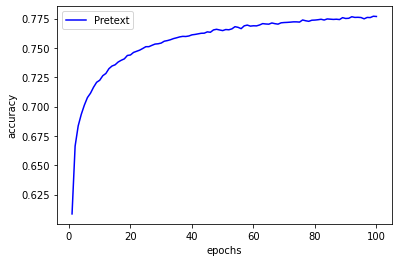

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,101),history.history['accuracy'],color='blue')
plt.legend(['Pretext'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
pretextmodel.save('/content/drive/MyDrive/ENGR-E-533 /DATA/HW3/Models/pretext_model.h5')

##Baseline Model

In [ ]:
baselinemodel = keras.Sequential([
    keras.layers.Conv2D(filters = 10,kernel_size = (5,5),strides = 1, activation = 'relu',data_format='channels_last',input_shape=(32,32,3)),
    keras.layers.MaxPool2D(pool_size = (2,2),strides = 2),
    keras.layers.Conv2D(filters = 10,kernel_size = (5,5),strides = 1, activation = 'relu',data_format='channels_last' ),
    keras.layers.MaxPool2D(pool_size = (2,2),strides = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 20, activation = 'relu', kernel_initializer='he_normal'),
    keras.layers.Dense(units = 10, activation = 'softmax', kernel_initializer = 'he_normal')
])

In [ ]:
baselinemodel.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])


In [ ]:
baselinemodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 10)       0         
 2D)                                                             
                                                                 
 conv2d_25 (Conv2D)          (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 10)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 20)               

In [ ]:
baselinehistory = baselinemodel.fit(X_train_label, 
          y_train_label,  
          epochs=10000,
          validation_data = (x_test, Y_test),
          verbose=1,
          batch_size=256)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 172ms/step - loss: 8.0585e-08 - accuracy: 1.0000 - val_loss: 15.4709 - val_accuracy: 0.3231
Epoch 7502/10000
2/2 [==============================] - 0s 173ms/step - loss: 7.9155e-08 - accuracy: 1.0000 - val_loss: 15.4715 - val_accuracy: 0.3232
Epoch 7503/10000
2/2 [==============================] - 0s 330ms/step - loss: 7.8440e-08 - accuracy: 1.0000 - val_loss: 15.4722 - val_accuracy: 0.3232
Epoch 7504/10000
2/2 [==============================] - 0s 181ms/step - loss: 7.9155e-08 - accuracy: 1.0000 - val_loss: 15.4730 - val_accuracy: 0.3231
Epoch 7505/10000
2/2 [==============================] - 0s 177ms/step - loss: 7.8678e-08 - accuracy: 1.0000 - val_loss: 15.4739 - val_accuracy: 0.3231
Epoch 7506/10000
2/2 [==============================] - 0s 176ms/step - loss: 8.0585e-08 - accuracy: 1.0000 - val_loss: 15.4747 - val_accuracy: 0.3231
Epoch 7507/10000
2/2 [==============================] - 0s 1

In [ ]:
baselinemodel.save('/content/drive/MyDrive/ENGR-E-533 /DATA/HW3/Models/baseline_model.h5')

###Graph for Baseline Val Accuracy

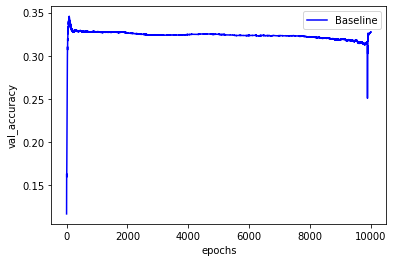

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,10001),baselinehistory.history['val_accuracy'],color='blue')
plt.legend(['Baseline'])
plt.xlabel('epochs')
plt.ylabel('val_accuracy')
plt.show()

##Transfer Learning

Ref and code: https://www.tensorflow.org/js/guide/models_and_layers

Layer wise optimizer customization: https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/MultiOptimizer

In [ ]:
TL_model = tf.keras.models.load_model('/content/drive/MyDrive/ENGR-E-533 /DATA/HW3/Models/pretext_model.h5')

In [ ]:
TL_model.get_weights()

[array([[[[-1.52041316e-01,  1.34023309e-01, -4.51274008e-01,
            3.04964066e-01,  1.26182437e-01, -2.15374127e-01,
            2.82275230e-01, -2.61086285e-01, -4.41893637e-01,
           -9.12377834e-02],
          [-3.26908916e-01, -3.22480276e-02,  2.74692565e-01,
            4.47803624e-02,  2.74485320e-01, -2.53079593e-01,
           -2.12561011e-01, -4.35868114e-01,  1.03322834e-01,
           -1.65477261e-01],
          [ 4.84521121e-01, -2.60127652e-02,  6.26456201e-01,
            9.65505764e-02,  2.21522197e-01,  2.93576896e-01,
            1.45062879e-01,  9.43494495e-03,  1.78020388e-01,
            3.54581624e-01]],
 
         [[-1.21657468e-01,  1.44893631e-01, -5.83551452e-02,
            3.56916673e-02,  1.19273663e-02, -1.29892528e-01,
            4.83888119e-01, -7.15143681e-01,  9.95607749e-02,
            4.50301096e-02],
          [-1.77964672e-01,  2.81967133e-01,  2.56484032e-01,
           -5.46866693e-02,  2.21969724e-01, -2.46462613e-01,
            1

In [ ]:
TL_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 10)       0         
 )                                                               
                                                                 
 conv2d_23 (Conv2D)          (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 10)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 250)               0         
                                                                 
 dense (Dense)               (None, 20)                5

In [ ]:
TL_model.pop()

In [ ]:
TL_model.add(Dense(10, activation='softmax', kernel_initializer='he_normal'))

In [ ]:
TL_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 10)       0         
 )                                                               
                                                                 
 conv2d_23 (Conv2D)          (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 10)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 250)               0         
                                                                 
 dense (Dense)               (None, 20)                5

In [ ]:
optimizers = [
    tf.keras.optimizers.Adam(learning_rate=1e-6),
    tf.keras.optimizers.Adam(learning_rate=1e-3)
]

In [ ]:
optimizers_and_layers = [(optimizers[0], TL_model.layers[:-1]), (optimizers[1], TL_model.layers[-1])]

In [ ]:
optimizer1 = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

In [ ]:
TL_model.compile(optimizer=optimizer1,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])


In [ ]:
TL_history = TL_model.fit(X_train_label, 
          y_train_label,  
          epochs=10000,
          validation_data = (x_test, Y_test),
          verbose=1,
          batch_size=256)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 122ms/step - loss: 1.2636 - accuracy: 0.5340 - val_loss: 2.5068 - val_accuracy: 0.3342
Epoch 7502/10000
2/2 [==============================] - 0s 126ms/step - loss: 1.2637 - accuracy: 0.5340 - val_loss: 2.5070 - val_accuracy: 0.3337
Epoch 7503/10000
2/2 [==============================] - 0s 118ms/step - loss: 1.2636 - accuracy: 0.5320 - val_loss: 2.5075 - val_accuracy: 0.3335
Epoch 7504/10000
2/2 [==============================] - 0s 121ms/step - loss: 1.2636 - accuracy: 0.5320 - val_loss: 2.5077 - val_accuracy: 0.3337
Epoch 7505/10000
2/2 [==============================] - 0s 113ms/step - loss: 1.2635 - accuracy: 0.5340 - val_loss: 2.5078 - val_accuracy: 0.3339
Epoch 7506/10000
2/2 [==============================] - 0s 114ms/step - loss: 1.2634 - accuracy: 0.5340 - val_loss: 2.5076 - val_accuracy: 0.3344
Epoch 7507/10000
2/2 [==============================] - 0s 116ms/step - loss: 1.2636 - acc

In [ ]:
TL_model.save('/content/drive/MyDrive/ENGR-E-533 /DATA/HW3/Models/TL_model.h5')

###Graph for Baseline vs Transfer Learning

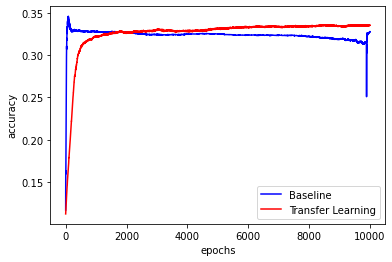

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,10001),baselinehistory.history['val_accuracy'],color='blue')
plt.plot(range(1,10001),TL_history.history['val_accuracy'],color='red')
plt.legend(['Baseline','Transfer Learning'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()